## INITIALIZATION

In [35]:
import os
import random
import shutil
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F


DATA_DIR = Path("data")
IMAGES_DIR = DATA_DIR / "Images"
ANNOTATIONS_DIR = DATA_DIR / "Annotation"
LISTS_DIR = DATA_DIR / "Lists"

TARGET_IMG_DIR = Path("working_data/images")
TARGET_ANN_DIR = Path("working_data/annotations")

## DATA CLEANING

In [36]:
i = 0
for folder in IMAGES_DIR.iterdir():
    if folder.is_dir():
        image_count = len(list(folder.glob("*.*"))) 
        print(f"{folder.name}: {image_count} images")

n02085620-Chihuahua: 152 images
n02085782-Japanese_spaniel: 185 images
n02085936-Maltese_dog: 252 images
n02086079-Pekinese: 149 images
n02086240-Shih-Tzu: 214 images
n02086646-Blenheim_spaniel: 188 images
n02086910-papillon: 196 images
n02087046-toy_terrier: 172 images
n02087394-Rhodesian_ridgeback: 172 images
n02088094-Afghan_hound: 239 images
n02088238-basset: 175 images
n02088364-beagle: 195 images
n02088466-bloodhound: 187 images
n02088632-bluetick: 171 images
n02089078-black-and-tan_coonhound: 159 images
n02089867-Walker_hound: 153 images
n02089973-English_foxhound: 157 images
n02090379-redbone: 148 images
n02090622-borzoi: 151 images
n02090721-Irish_wolfhound: 218 images
n02091032-Italian_greyhound: 182 images
n02091134-whippet: 187 images
n02091244-Ibizan_hound: 188 images
n02091467-Norwegian_elkhound: 196 images
n02091635-otterhound: 151 images
n02091831-Saluki: 200 images
n02092002-Scottish_deerhound: 232 images
n02092339-Weimaraner: 160 images
n02093256-Staffordshire_bullter

In [37]:
all_breeds = sorted([d.name for d in IMAGES_DIR.iterdir() if d.is_dir()])
print(f"Total breeds: {len(all_breeds)}")

random.seed(739)

# Reduced to 20 for Trial 3 from 30
selected_breeds = random.sample(all_breeds, 20)
print("Selected Breeds:\n", selected_breeds)

Total breeds: 120
Selected Breeds:
 ['n02091635-otterhound', 'n02109047-Great_Dane', 'n02107683-Bernese_mountain_dog', 'n02097047-miniature_schnauzer', 'n02100735-English_setter', 'n02108000-EntleBucher', 'n02091467-Norwegian_elkhound', 'n02107142-Doberman', 'n02090379-redbone', 'n02086240-Shih-Tzu', 'n02087394-Rhodesian_ridgeback', 'n02098105-soft-coated_wheaten_terrier', 'n02092339-Weimaraner', 'n02116738-African_hunting_dog', 'n02108422-bull_mastiff', 'n02098413-Lhasa', 'n02112018-Pomeranian', 'n02109525-Saint_Bernard', 'n02106166-Border_collie', 'n02102480-Sussex_spaniel']


In [38]:
def clear_directory(directory):
    if directory.exists() and directory.is_dir():
        for file in directory.iterdir():
            if file.is_file():
                file.unlink()
            elif file.is_dir():
                import shutil
                shutil.rmtree(file)

clear_directory(TARGET_IMG_DIR)
clear_directory(TARGET_ANN_DIR)

In [39]:
for breed in selected_breeds:
    breed_img_dir = IMAGES_DIR / breed
    breed_ann_dir = ANNOTATIONS_DIR / breed

    imgs = list(breed_img_dir.glob("*.jpg"))
    # for trial 2, increased image sampling from 100 to 175 per breed
    # for trial 3, removed image cap per breed
    # selected_imgs = random.sample(imgs, min(175, len(imgs)))
    selected_imgs = imgs

    for img_path in selected_imgs:
        # Copy image
        dest_img_dir = TARGET_IMG_DIR / breed
        dest_img_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, dest_img_dir / img_path.name)

        # Find corresponding annotation 
        base_name = img_path.stem  # n02085782_2
        annot_path = breed_ann_dir / base_name 

        if annot_path.exists():
            dest_ann_dir = TARGET_ANN_DIR / breed
            dest_ann_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy(annot_path, dest_ann_dir / annot_path.name)
        else:
            print(f"Annotation missing for image {img_path.name}")

## TRIAL 1

## TRANSFORMATION

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224\
    transforms.ToTensor(),            # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset from subset folder
dataset = ImageFolder(root=str(TARGET_IMG_DIR), transform=transform)

print(f"Total images in subset: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")

# Split dataset into train and test sets 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

# Create DataLoaders for batching
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Total images in subset: 4699
Number of classes: 30
Class names: ['n02086240-Shih-Tzu', 'n02087394-Rhodesian_ridgeback', 'n02088466-bloodhound', 'n02090379-redbone', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02092339-Weimaraner', 'n02094433-Yorkshire_terrier', 'n02096177-cairn', 'n02096437-Dandie_Dinmont', 'n02097047-miniature_schnauzer', 'n02098105-soft-coated_wheaten_terrier', 'n02098413-Lhasa', 'n02100735-English_setter', 'n02102480-Sussex_spaniel', 'n02104365-schipperke', 'n02105251-briard', 'n02105641-Old_English_sheepdog', 'n02106166-Border_collie', 'n02106662-German_shepherd', 'n02107142-Doberman', 'n02107574-Greater_Swiss_Mountain_dog', 'n02107683-Bernese_mountain_dog', 'n02108000-EntleBucher', 'n02108089-boxer', 'n02108422-bull_mastiff', 'n02109047-Great_Dane', 'n02109525-Saint_Bernard', 'n02112137-chow', 'n02113624-toy_poodle']
Train size: 3759, Test size: 940


## CNN

In [6]:
class SimpleDogCNN(nn.Module):
    def __init__(self, num_classes=30):
        super(SimpleDogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # input RGB channels=3
        self.pool = nn.MaxPool2d(2, 2)  # downsample by factor of 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # assuming input size 224x224
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (224 -> 112)
        x = self.pool(F.relu(self.conv2(x)))  # (112 -> 56)
        x = self.pool(F.relu(self.conv3(x)))  # (56 -> 28)
        x = x.view(-1, 128 * 28 * 28)         # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model and send to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleDogCNN(num_classes=30).to(device)
print(model)


SimpleDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 10
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_model(model, test_loader, criterion, device)

    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")


Epoch 1/10 - Train loss: 3.4654, Train acc: 0.0327 | Val loss: 3.3995, Val acc: 0.0457 | Time: 315.4s
Epoch 2/10 - Train loss: 3.3946, Train acc: 0.0463 | Val loss: 3.5048, Val acc: 0.0330 | Time: 289.1s
Epoch 3/10 - Train loss: 3.3038, Train acc: 0.0785 | Val loss: 3.2556, Val acc: 0.0819 | Time: 360.7s
Epoch 4/10 - Train loss: 2.9217, Train acc: 0.1785 | Val loss: 3.4022, Val acc: 0.0798 | Time: 310.7s
Epoch 5/10 - Train loss: 1.9219, Train acc: 0.4605 | Val loss: 4.0709, Val acc: 0.0798 | Time: 314.5s
Epoch 6/10 - Train loss: 0.5619, Train acc: 0.8476 | Val loss: 6.9316, Val acc: 0.0872 | Time: 356.4s
Epoch 7/10 - Train loss: 0.1074, Train acc: 0.9726 | Val loss: 8.6180, Val acc: 0.0979 | Time: 333.1s
Epoch 8/10 - Train loss: 0.0382, Train acc: 0.9910 | Val loss: 9.7904, Val acc: 0.0979 | Time: 342.5s
Epoch 9/10 - Train loss: 0.0228, Train acc: 0.9957 | Val loss: 9.7120, Val acc: 0.0894 | Time: 294.0s
Epoch 10/10 - Train loss: 0.0064, Train acc: 0.9989 | Val loss: 10.6442, Val acc: 

Clear overfitting - high training acc but low val acc and high val loss

## TRIAL 2

In [2]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Only normalization for validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Paths
TARGET_IMG_DIR = Path("working_data/images")

# Load datasets
full_dataset = ImageFolder(root=str(TARGET_IMG_DIR), transform=train_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply test transforms to test dataset manually
test_dataset.dataset.transform = test_transform

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
class SimpleDogCNN(nn.Module):
    def __init__(self, num_classes=30):
        super(SimpleDogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleDogCNN(num_classes=30).to(device)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [5]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=40):
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        train_acc = correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= val_total
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Time: {elapsed:.2f}s")


In [ ]:
# Trial 2 before I added in time stats and increased image sampling to 175 from 100

# Epoch 1/10 - Train Loss: 3.3983, Train Acc: 0.0423 - Val Loss: 3.3788, Val Acc: 0.0553
# Epoch 2/10 - Train Loss: 3.3586, Train Acc: 0.0521 - Val Loss: 3.3306, Val Acc: 0.0532
# Epoch 3/10 - Train Loss: 3.3272, Train Acc: 0.0660 - Val Loss: 3.3127, Val Acc: 0.0628
# Epoch 4/10 - Train Loss: 3.2889, Train Acc: 0.0766 - Val Loss: 3.2833, Val Acc: 0.0617
# Epoch 5/10 - Train Loss: 3.2566, Train Acc: 0.0793 - Val Loss: 3.2485, Val Acc: 0.0691
# Epoch 6/10 - Train Loss: 3.2060, Train Acc: 0.0950 - Val Loss: 3.2163, Val Acc: 0.0830
# Epoch 7/10 - Train Loss: 3.1721, Train Acc: 0.1019 - Val Loss: 3.1841, Val Acc: 0.0755
# Epoch 8/10 - Train Loss: 3.1335, Train Acc: 0.1016 - Val Loss: 3.1591, Val Acc: 0.0926

# Restarted kernel and re ran after change

In [6]:
train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=40)

Epoch 1/40 - Train Loss: 3.3915, Train Acc: 0.0446 - Val Loss: 3.3443, Val Acc: 0.0614 - Time: 226.99s
Epoch 2/40 - Train Loss: 3.3368, Train Acc: 0.0575 - Val Loss: 3.2970, Val Acc: 0.0833 - Time: 222.52s
Epoch 3/40 - Train Loss: 3.3114, Train Acc: 0.0662 - Val Loss: 3.2711, Val Acc: 0.0793 - Time: 221.47s
Epoch 4/40 - Train Loss: 3.2844, Train Acc: 0.0692 - Val Loss: 3.2384, Val Acc: 0.0793 - Time: 220.76s
Epoch 5/40 - Train Loss: 3.2537, Train Acc: 0.0811 - Val Loss: 3.2062, Val Acc: 0.0842 - Time: 220.60s
Epoch 6/40 - Train Loss: 3.2075, Train Acc: 0.0883 - Val Loss: 3.1796, Val Acc: 0.1011 - Time: 226.24s
Epoch 7/40 - Train Loss: 3.1684, Train Acc: 0.1069 - Val Loss: 3.1580, Val Acc: 0.1110 - Time: 225.21s
Epoch 8/40 - Train Loss: 3.1257, Train Acc: 0.1108 - Val Loss: 3.1218, Val Acc: 0.1100 - Time: 255.59s
Epoch 9/40 - Train Loss: 3.0865, Train Acc: 0.1128 - Val Loss: 3.0657, Val Acc: 0.1229 - Time: 313.17s
Epoch 10/40 - Train Loss: 3.0361, Train Acc: 0.1255 - Val Loss: 3.1000, V

KeyboardInterrupt: 

In [ ]:
#Kernel interrupted, plateauing

## TRIAL 3

In [11]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Only normalization for validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Paths
TARGET_IMG_DIR = Path("working_data/images")

# Load datasets
full_dataset = ImageFolder(root=str(TARGET_IMG_DIR), transform=train_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply test transforms to test dataset manually
test_dataset.dataset.transform = test_transform

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=30).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20):
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        train_acc = correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= val_total
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Time: {elapsed:.2f}s")


In [15]:
train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)

Epoch 1/20 - Train Loss: 2.9435, Train Acc: 0.1083 - Val Loss: 2.9286, Val Acc: 0.1221 - Time: 367.24s
Epoch 2/20 - Train Loss: 2.7981, Train Acc: 0.1407 - Val Loss: 2.8358, Val Acc: 0.1366 - Time: 314.17s
Epoch 3/20 - Train Loss: 2.6887, Train Acc: 0.1901 - Val Loss: 2.8754, Val Acc: 0.1323 - Time: 330.19s
Epoch 4/20 - Train Loss: 2.5946, Train Acc: 0.2119 - Val Loss: 2.7968, Val Acc: 0.1599 - Time: 337.97s
Epoch 5/20 - Train Loss: 2.5307, Train Acc: 0.2308 - Val Loss: 2.7138, Val Acc: 0.1831 - Time: 368.57s
Epoch 6/20 - Train Loss: 2.3889, Train Acc: 0.2755 - Val Loss: 2.4585, Val Acc: 0.2369 - Time: 323.54s
Epoch 7/20 - Train Loss: 2.3211, Train Acc: 0.2886 - Val Loss: 2.4259, Val Acc: 0.2355 - Time: 300.11s
Epoch 8/20 - Train Loss: 2.2712, Train Acc: 0.3108 - Val Loss: 2.3658, Val Acc: 0.2747 - Time: 262.19s
Epoch 9/20 - Train Loss: 2.2134, Train Acc: 0.3264 - Val Loss: 2.3587, Val Acc: 0.2544 - Time: 299.17s
Epoch 10/20 - Train Loss: 2.1927, Train Acc: 0.3326 - Val Loss: 2.3051, V

KeyboardInterrupt: 

In [16]:
#Kernel interrupted, plateauing

## TRIAL 4

In [40]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Only normalization for validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

TARGET_IMG_DIR = Path("working_data/images")

full_dataset = ImageFolder(root=str(TARGET_IMG_DIR), transform=train_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transform

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=20).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20, early_stop_patience=5):
    best_val_acc = 0.0
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= val_total
        elapsed = time.time() - start_time

        # Scheduler step on validation accuracy
        scheduler.step(val_acc)

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Time: {elapsed:.2f}s")

        if epochs_no_improve >= early_stop_patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}. Best Val Acc: {best_val_acc:.4f} at epoch {best_epoch+1}")
            break

In [41]:
train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20)

Epoch 1/20 - Train Loss: 2.9203, Train Acc: 0.1087 - Val Loss: 2.8305, Val Acc: 0.1279 - Time: 526.94s
Epoch 2/20 - Train Loss: 2.8011, Train Acc: 0.1410 - Val Loss: 2.8425, Val Acc: 0.1497 - Time: 568.67s
Epoch 3/20 - Train Loss: 2.7114, Train Acc: 0.1625 - Val Loss: 2.7429, Val Acc: 0.1483 - Time: 494.88s
Epoch 4/20 - Train Loss: 2.6270, Train Acc: 0.1890 - Val Loss: 2.6551, Val Acc: 0.2035 - Time: 383.16s
Epoch 5/20 - Train Loss: 2.5681, Train Acc: 0.2028 - Val Loss: 2.5625, Val Acc: 0.2166 - Time: 376.42s
Epoch 6/20 - Train Loss: 2.4735, Train Acc: 0.2210 - Val Loss: 2.6325, Val Acc: 0.2078 - Time: 424.73s
Epoch 7/20 - Train Loss: 2.4458, Train Acc: 0.2530 - Val Loss: 2.6531, Val Acc: 0.1933 - Time: 492.26s
Epoch 8/20 - Train Loss: 2.3818, Train Acc: 0.2585 - Val Loss: 2.4878, Val Acc: 0.2267 - Time: 337.27s
Epoch 9/20 - Train Loss: 2.3395, Train Acc: 0.2646 - Val Loss: 2.3542, Val Acc: 0.2980 - Time: 347.50s
Epoch 10/20 - Train Loss: 2.2636, Train Acc: 0.2973 - Val Loss: 2.4656, V

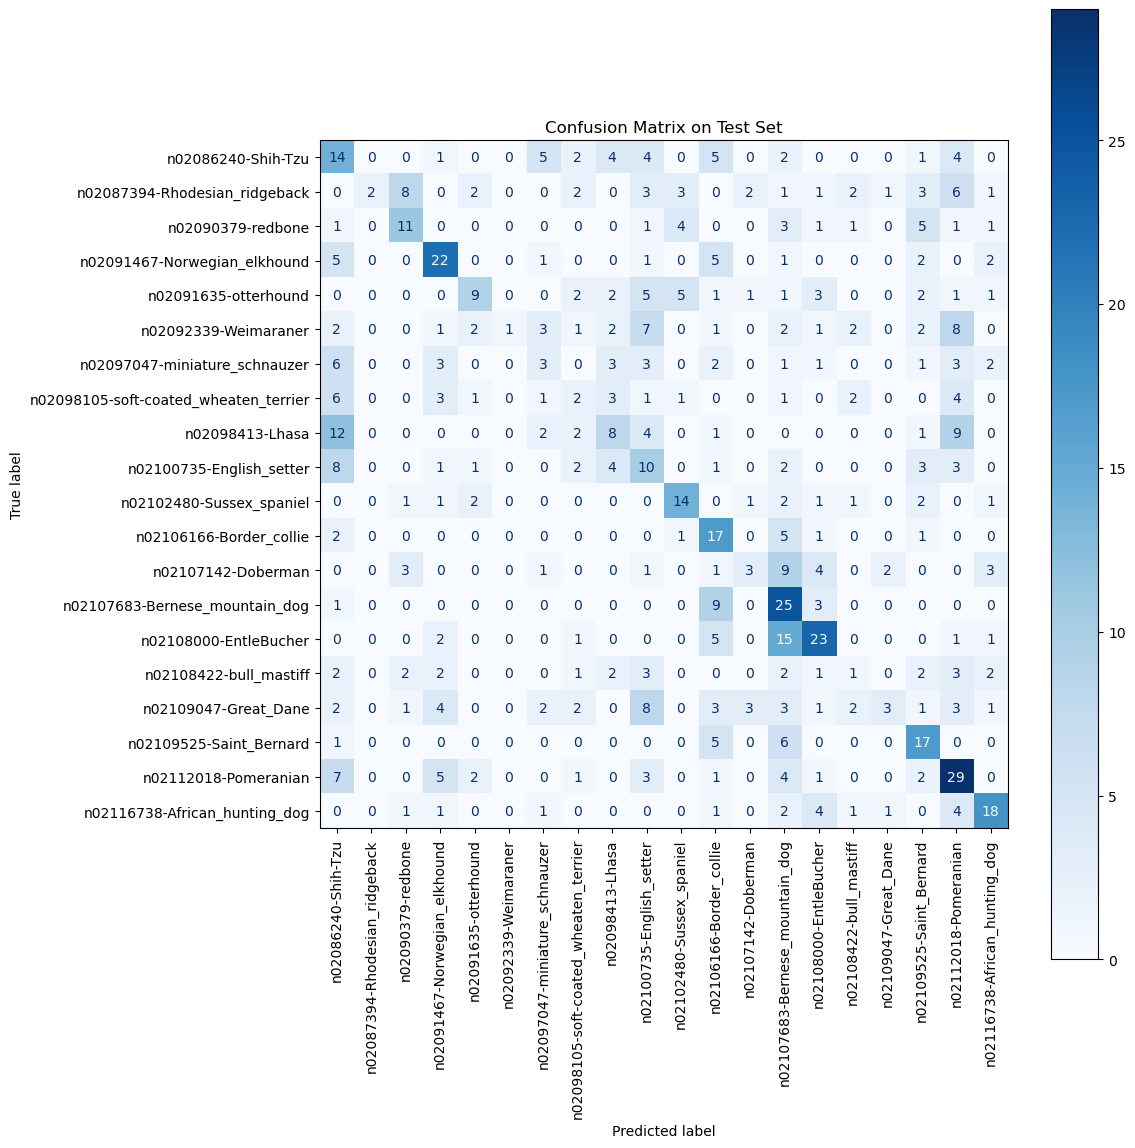


Classification Report:

                                       precision    recall  f1-score   support

                   n02086240-Shih-Tzu       0.20      0.33      0.25        42
        n02087394-Rhodesian_ridgeback       1.00      0.05      0.10        37
                    n02090379-redbone       0.41      0.38      0.39        29
         n02091467-Norwegian_elkhound       0.48      0.56      0.52        39
                 n02091635-otterhound       0.47      0.27      0.35        33
                 n02092339-Weimaraner       1.00      0.03      0.06        35
        n02097047-miniature_schnauzer       0.16      0.11      0.13        28
n02098105-soft-coated_wheaten_terrier       0.11      0.08      0.09        25
                      n02098413-Lhasa       0.29      0.21      0.24        39
             n02100735-English_setter       0.19      0.29      0.22        35
             n02102480-Sussex_spaniel       0.50      0.54      0.52        26
              n02106166-Bo

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size as needed
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


In [47]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=20, bias=True)
)

In [52]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
      BatchNorm2d-11          [-1, 256, 28, 28]             512
        MaxPool2d-12          [-1, 256, 14, 14]               0
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
          Dropout-14                  [

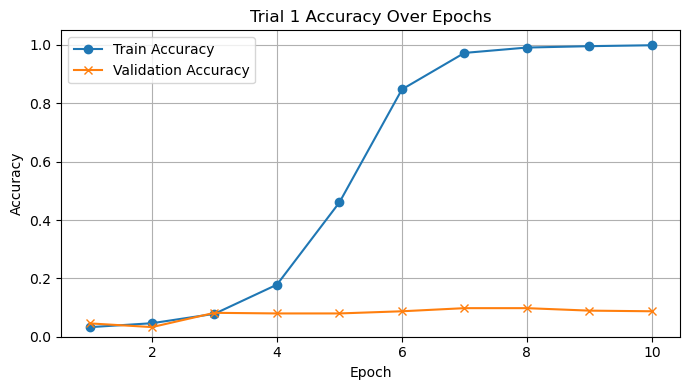

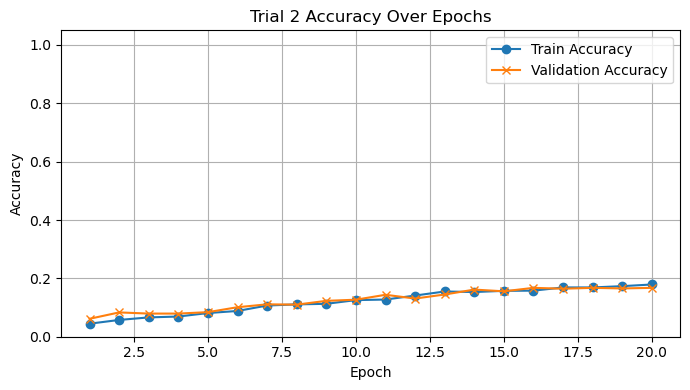

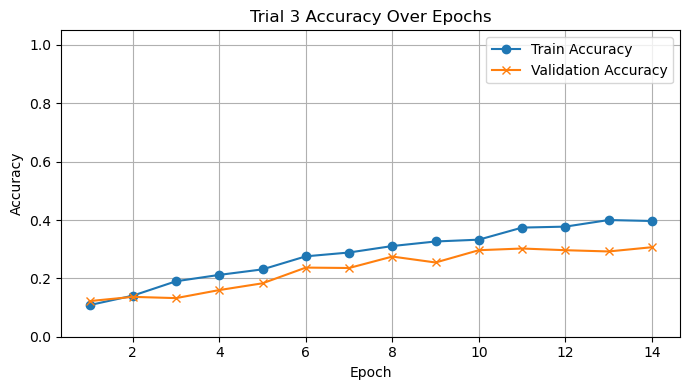

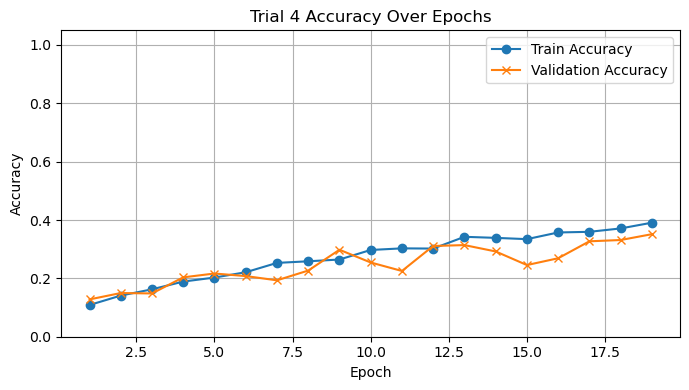

In [54]:
import matplotlib.pyplot as plt

# Trial 1 data
trial1_train_acc = [0.0327, 0.0463, 0.0785, 0.1785, 0.4605, 0.8476, 0.9726, 0.9910, 0.9957, 0.9989]
trial1_val_acc   = [0.0457, 0.0330, 0.0819, 0.0798, 0.0798, 0.0872, 0.0979, 0.0979, 0.0894, 0.0872]

# Trial 2 data
trial2_train_acc = [0.0446, 0.0575, 0.0662, 0.0692, 0.0811, 0.0883, 0.1069, 0.1108, 0.1128, 0.1255,
                    0.1274, 0.1411, 0.1550, 0.1532, 0.1572, 0.1579, 0.1689, 0.1689, 0.1733, 0.1790]
trial2_val_acc   = [0.0614, 0.0833, 0.0793, 0.0793, 0.0842, 0.1011, 0.1110, 0.1100, 0.1229, 0.1269,
                    0.1437, 0.1308, 0.1447, 0.1615, 0.1556, 0.1675, 0.1645, 0.1675, 0.1655, 0.1675]

# Trial 3 data
trial3_train_acc = [0.1083, 0.1407, 0.1901, 0.2119, 0.2308, 0.2755, 0.2886, 0.3108, 0.3264, 0.3326,
                    0.3740, 0.3773, 0.3999, 0.3966]
trial3_val_acc   = [0.1221, 0.1366, 0.1323, 0.1599, 0.1831, 0.2369, 0.2355, 0.2747, 0.2544, 0.2965,
                    0.3023, 0.2965, 0.2922, 0.3067]

# Trial 4 data
trial4_train_acc = [0.1087, 0.1410, 0.1625, 0.1890, 0.2028, 0.2210, 0.2530, 0.2585, 0.2646, 0.2973,
                    0.3028, 0.3021, 0.3424, 0.3388, 0.3344, 0.3573, 0.3595, 0.3711, 0.3908]
trial4_val_acc   = [0.1279, 0.1497, 0.1483, 0.2035, 0.2166, 0.2078, 0.1933, 0.2267, 0.2980, 0.2544,
                    0.2253, 0.3110, 0.3140, 0.2922, 0.2456, 0.2689, 0.3270, 0.3314, 0.3514]

# Function to plot each trial
def plot_trial(train_acc, val_acc, trial_number):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='x')
    plt.title(f'Trial {trial_number} Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'trial_{trial_number}_accuracy.png')
    plt.show()

# Generate plots
plot_trial(trial1_train_acc, trial1_val_acc, 1)
plot_trial(trial2_train_acc, trial2_val_acc, 2)
plot_trial(trial3_train_acc, trial3_val_acc, 3)
plot_trial(trial4_train_acc, trial4_val_acc, 4)
